In [3]:
import wrds
import pandas as pd
import numpy as np
from pandas.tseries.offsets import *
from scipy import stats
import datetime as dt

import matplotlib.pyplot as plt

In [4]:
conn = wrds.Connection()

Loading library list...
Done


# Download tables

In [68]:
famafrench = conn.get_table(library='ff', table='factors_monthly')
famafrench['yyyymm'] =  famafrench['date'].apply(lambda x: dt.datetime.strftime(x, '%Y%m')) 
famafrench['yyyymm'] = famafrench.yyyymm.astype(int)
# famafrench = famafrench.loc[(famafrench['yyyymm'] >= 197001) & (famafrench['yyyymm'] < 202201)]


In [69]:
crsp = conn.raw_sql(
    """
    select a.permno, a.permco, a.date, a.ret, a.retx, a.vol, a.shrout, a.prc, a.cfacshr, a.bidlo, a.askhi,
    b.comnam, b.shrcd, b.exchcd, b.siccd, b.ticker, b.shrcls,          -- from identifying info table
    c.dlstcd, c.dlret                                                  -- from delistings table
    from crsp.msf as a
    left join crsp.msenames as b
    on a.permno=b.permno
    and b.namedt<=a.date
    and a.date<=b.nameendt
    left join crsp.msedelist as c
    on a.permno=c.permno
    and date_trunc('month', a.date) = date_trunc('month', c.dlstdt)
    where a.date between '01/01/1970' and '12/31/2021'
    """, 
    date_cols=['date'])

# Pre-processing

In [70]:
# Exclude entries in which a good price is missing
crsp = crsp.dropna(subset='prc')

# Exclude months in which the share code is missing
crsp = crsp.dropna(subset='shrcd')

In [71]:
# Move date to end of the month
crsp['date']=crsp['date']+MonthEnd(0)

# Create yearmonth column
crsp['yyyymm'] =  crsp['date'].apply(lambda x: dt.datetime.strftime(x, '%Y%m')) 
crsp['yyyymm'] = crsp.yyyymm.astype(int)

### Deal with de-listing returns

In [72]:
# following https://wrds-www.wharton.upenn.edu/pages/support/applications/python-replications/fama-french-factors-python/
crsp['dlret'] = crsp['dlret'].fillna(0)
crsp['ret'] = crsp['ret'].fillna(0)
crsp = crsp.loc[crsp['dlret'] != -1]
crsp['retadj'] = (1+crsp['ret'])*(1+crsp['dlret'])-1

crsp=crsp.drop(['dlret'], axis=1)

In [73]:
crsp_checkpoint = crsp.copy()

## Market equity adjustment
Calculate market equity for each permno, then merge the permnos with same permco, keep only the one with the largest permco

In [74]:
# calculate market equity
crsp['me']=crsp['prc'].abs()*crsp['shrout'] 
crsp=crsp.sort_values(by=['date','permco','me'])

### Aggregate Market Cap ###
# sum of me across different permno belonging to same permco in a given date
crsp_summe = crsp.groupby(['date','permco'])['me'].sum().reset_index()

# largest mktcap within a permco/date
crsp_maxme = crsp.groupby(['date','permco'])['me'].max().reset_index()



In [75]:
# join by jdate/maxme to find the permno
crsp1=pd.merge(crsp, crsp_maxme, how='inner', on=['date','permco','me'])

# drop me column and replace with the sum me
crsp1=crsp1.drop(['me'], axis=1)

# join with sum of me to get the correct market cap info
crsp2=pd.merge(crsp1, crsp_summe, how='inner', on=['date','permco'])

# sort by permno and date and also drop duplicates
crsp2=crsp2.sort_values(by=['permno','date']).drop_duplicates()

In [76]:
crsp = crsp2.copy()

# Calculate melag and adjust for first month
crsp['count']=crsp.groupby(['permno']).cumcount()
crsp['melag'] = crsp.groupby('permno')['me'].shift()
crsp['melag'] = np.where(crsp['count'] == 0, crsp['me']/(1+crsp['retx']), crsp['melag']) # ret or retx?
# crsp['me'] = crsp['me']/1000
# crsp['melag'] = crsp['melag']/1000


### Filter for exchange code (1,2,3) and shrcd (10,11)

In [77]:
crsp = crsp.loc[(crsp['exchcd'].isin([1,2,3])) & (crsp.shrcd.isin([10,11]))]


# Calculate Momentum

In [78]:
_tmp_crsp = crsp[['permno','date','retadj']].sort_values(['permno','date']).set_index('date').copy()

# Replace missing return with 0
_tmp_crsp['retadj']=_tmp_crsp['retadj'].fillna(0)

# Calculate rolling cumulative return
# by summing log(1+ret) over the formation period
_tmp_crsp['logret']=np.log(1+_tmp_crsp['retadj'])
umd = _tmp_crsp.groupby(['permno'])['logret'].rolling(11).sum()
umd = umd.reset_index()
umd['cumret']=np.exp(umd['logret'])-1
umd.drop('logret', axis=1, inplace=True)
# Merge back to crsp
crsp = crsp.merge(umd, on=['permno','date'], how='left')


# Calculating NYSE Size breakpoints

In [79]:
crsp_nyse_me = crsp.loc[crsp['exchcd'] == 1].copy()
crsp_nyse_me = crsp_nyse_me.loc[(crsp_nyse_me['shrcd'].isin([10,11])) & (~crsp_nyse_me['melag'].isna())].copy()

size_breakpoints = pd.DataFrame(crsp_nyse_me.groupby('yyyymm')['melag'].agg('median'))
size_breakpoints = size_breakpoints.reset_index(drop=False)
size_breakpoints = size_breakpoints.rename({'melag':'me_nyse50'}, axis=1)

size_breakpoints['me_nyse50'] = size_breakpoints['me_nyse50']
size_breakpoints.head()

,yyyymm,me_nyse50
0,197001,145031.250361
1,197002,131709.000000
2,197003,137543.125000
3,197004,135189.062500
4,197005,118926.000000


# Calculating NYSE Mom breakpoints

In [80]:
crsp_nyse_mom = crsp.loc[crsp['exchcd'] == 1].copy()
crsp_nyse_mom = crsp_nyse_mom.loc[(crsp_nyse_mom['shrcd'].isin([10,11])) & (~crsp_nyse_mom['melag'].isna())].copy()

# Sort values by yyyymm
crsp_nyse_mom = crsp_nyse_mom.sort_values('yyyymm')
crsp_nyse_mom = crsp_nyse_mom.reset_index(drop=True)

In [81]:
crsp_nyse_mom['ret_t-12'] = crsp_nyse_mom.groupby('permno')['ret'].shift(12)
crsp_nyse_mom['prc_t-12'] = crsp_nyse_mom.groupby('permno')['prc'].shift(12)
crsp_nyse_mom['ret_t-1'] = crsp_nyse_mom.groupby('permno')['ret'].shift(1)
crsp_nyse_mom['date_t-12'] = (crsp_nyse_mom['date']  - pd.DateOffset(months=12))
crsp_nyse_mom['date_t-1'] = (crsp_nyse_mom['date']  - pd.DateOffset(months=1))

crsp_nyse_mom['date_t-1']=crsp_nyse_mom['date_t-1']+MonthEnd(0)
crsp_nyse_mom['date_t-12']=crsp_nyse_mom['date_t-12']+MonthEnd(0)

s = crsp_nyse_mom.groupby('permno').apply(lambda x: (x['date_t-1'].isin(x['date']) & (x['ret_t-1'] != -0.99) & (~x['ret_t-1'].isna())))
crsp_nyse_mom['t-1_check'] = s.reset_index(level=0)[0]
s = crsp_nyse_mom.groupby('permno').apply(lambda x: (x['date_t-12'].isin(x['date'])))# & (~x['prc_t-12'].isna()))
crsp_nyse_mom['present_t-12'] = s.reset_index(level=0)['date_t-12']#[0]

In [82]:
crsp_nyse_mom['mom'] = crsp_nyse_mom.groupby('permno')['cumret'].shift(2)

# Select valid rows only, according to Fama & French the stock must have a valid return in 
crsp_nyse_mom= crsp_nyse_mom.loc[(crsp_nyse_mom['present_t-12'] == True) & (crsp_nyse_mom['t-1_check'] == True)].copy()

In [83]:
# Breakpoints calculation

mom_breakpoints = crsp_nyse_mom.groupby('yyyymm')['mom'].quantile(.3).reset_index(drop=False).copy()
mom_breakpoints = mom_breakpoints.rename({'mom': "mom_nyse30"}, axis=1)
mom_breakpoints['mom_nyse50'] = crsp_nyse_mom.groupby('yyyymm')['mom'].quantile(.5).reset_index(drop=True)
mom_breakpoints['mom_nyse70'] = crsp_nyse_mom.groupby('yyyymm')['mom'].quantile(.7).reset_index(drop=True)

mom_breakpoints.iloc[:,1:] = mom_breakpoints.iloc[:,1:]
mom_breakpoints.head()

,yyyymm,mom_nyse30,mom_nyse50,mom_nyse70
0,197101,-0.253159,-0.101374,0.023059
1,197102,-0.116548,0.049769,0.167781
2,197103,-0.068245,0.066166,0.179682
3,197104,-0.026170,0.088904,0.196020
4,197105,0.148437,0.271316,0.431011


## Portfolio - prep phase

In [84]:
crsp = crsp.loc[(crsp['shrcd'].isin([10,11])) & (crsp['exchcd'].isin([1,2,3])) & (~crsp['melag'].isna())].copy()

In [85]:
crsp = crsp.sort_values('yyyymm')
crsp = crsp.reset_index(drop=True)

crsp['ret_t-12'] = crsp.groupby('permno')['ret'].shift(12)
crsp['prc_t-12'] = crsp.groupby('permno')['prc'].shift(12)
crsp['ret_t-1'] = crsp.groupby('permno')['ret'].shift(1)
crsp['date_t-12'] = (crsp['date']  - pd.DateOffset(months=12))
crsp['date_t-1'] = (crsp['date']  - pd.DateOffset(months=1))

crsp['date_t-1'] = crsp['date_t-1']+MonthEnd(0)
crsp['date_t-12'] = crsp['date_t-12']+MonthEnd(0)

s = crsp.groupby('permno').apply(lambda x: (x['date_t-1'].isin(x['date']) & (x['ret_t-1'] != -0.99) & (~x['ret_t-1'].isna())))
crsp['t-1_check'] = s.reset_index(level=0)[0]
s = crsp.groupby('permno').apply(lambda x: (x['date_t-12'].isin(x['date'])))# & (~x['prc_t-12'].isna()))
crsp['present_t-12'] = s.reset_index(level=0)['date_t-12']#[0]

In [86]:
crsp['mom'] = crsp.groupby('permno')['cumret'].shift(2)

# Select valid rows only, according to Fama & French the stock must have a valid return in 
crsp = crsp.loc[(crsp['present_t-12'] == True) & (crsp['t-1_check'] == True)].copy()

In [87]:
crsp = crsp.dropna(subset='mom')

From now on, there will be two different methods for calculating portfolio returns, and the relative correlation

# Portfolio returns calculation

In [88]:
crsp = crsp.merge(size_breakpoints, on='yyyymm', how='left')
crsp = crsp.merge(mom_breakpoints, on='yyyymm', how='left')

In [89]:
crsp_checkpoint = crsp.copy()

### Method 1

In [90]:
crsp = crsp_checkpoint.copy()

conditions =[
    (crsp['melag'] < crsp['me_nyse50']),
    (crsp['melag'] >= crsp['me_nyse50']),
]
values = ['Small', 'Big']

crsp['SizeCat'] = np.select(conditions, values)


conditions =[
    (crsp['mom'] < crsp['mom_nyse30']),
    ((crsp['mom'] >= crsp['mom_nyse30']) & (crsp['mom'] < crsp['mom_nyse70'])),
    (crsp['mom'] >= crsp['mom_nyse70'])
]
values = ['Low', 'Medium', 'High']

crsp['MomCat'] = np.select(conditions, values)


# Create combined portfolio category
crsp['Port'] = crsp.SizeCat.str.cat(crsp.MomCat, sep='-')

# Filters
crsp = crsp.loc[
    (pd.notnull(crsp['me'])) & 
    ((crsp['Port'] != '0')) & 
    (pd.notnull(crsp['yyyymm']))
    ].copy()
    
# crsp.loc[pd.isnull(crsp['ret']), 'ret'] = 0
crsp = crsp.sort_values(by=['permno','yyyymm'])

# crsp.drop(['total_me_x','total_me_y', 'total_me'], axis=1, inplace=True, errors='ignore')

# Create portfolio weights
weight = pd.DataFrame(crsp.groupby(['yyyymm','Port'])['melag'].sum()).reset_index(drop=False)
weight = weight.rename(columns={'melag':'total_melag'})
crsp = pd.merge(crsp,weight,on=['yyyymm','Port'], how='inner')
crsp['weight'] = crsp['melag'] / crsp['total_melag']


# Calculate portfolio returns
crsp = (crsp.sort_values(by=['permno','yyyymm'])).reset_index(drop=True)
crsp['vw_ret'] = crsp['ret'] * crsp['weight']#.shift()  #use shift to get last periods value weight
crsp.loc[crsp['permno'] != crsp['permno'].shift(), 'vw_ret'] = np.nan



# Create returns portfolio
monthly_vw = crsp.groupby(['yyyymm','Port'])['vw_ret'].sum()
monthly_vw = monthly_vw.unstack('Port')
monthly_vw = monthly_vw.reset_index(drop=False)
monthly_vw = monthly_vw.iloc[1:,:]
monthly_vw.head()


# Create UMD factor
monthly_vw['mom'] = 0.5*(monthly_vw['Small-High'] + monthly_vw['Big-High']) - 0.5 * (monthly_vw['Small-Low'] + monthly_vw['Big-Low'])
umd = monthly_vw[['yyyymm','mom']]


# Adjust Fama French
famafrench['yyyymm'] =  famafrench['date'].apply(lambda x: dt.datetime.strftime(x, '%Y%m')) 
famafrench['yyyymm'] = famafrench.yyyymm.astype(int)


# Calculate correlation of created UMD with FF UMD
momentum_check = pd.merge(umd, famafrench[['yyyymm','umd']], on=['yyyymm'], how='inner')
momentum_check = momentum_check.dropna()

port_corr = stats.pearsonr(momentum_check['mom'], momentum_check['umd'])
print(f'Mom returns correlation: {round(port_corr[0]*100,1)}%')

Mom returns correlation: 99.9%


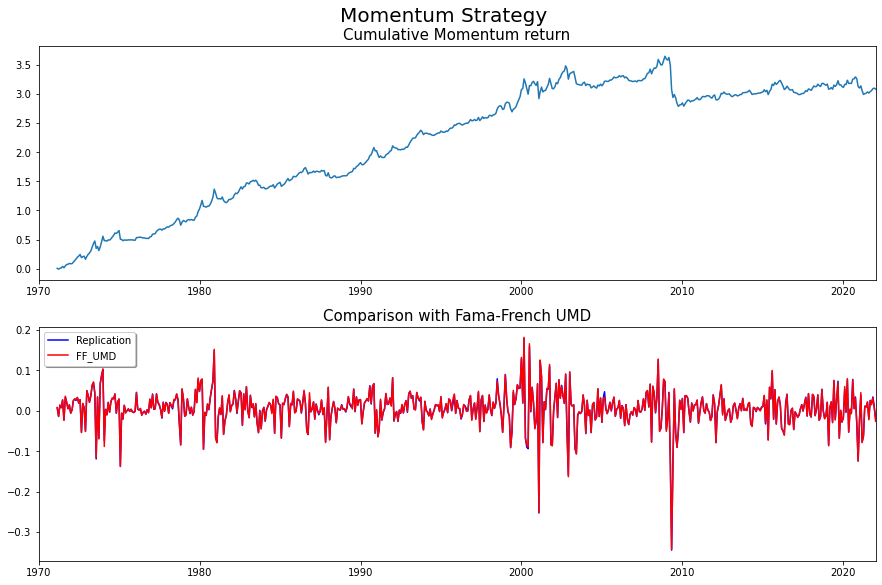

In [91]:
momentum_check['cumulative_mom'] = np.log(1+momentum_check['mom']).cumsum()
momentum_check['date'] = momentum_check['yyyymm'].apply(lambda x: dt.datetime.strptime(str(x), '%Y%m'))
momentum_check['date'] = momentum_check.date + MonthEnd(0)
momentum_check = momentum_check.set_index(momentum_check['date'])

plt.figure(figsize=(15,9))
plt.suptitle('Momentum Strategy', fontsize=20)
ax1 = plt.subplot(211)
ax1.set_title('Cumulative Momentum return', fontsize=15)
ax1.set_xlim([dt.datetime(1970,1,1), dt.datetime(2021,12,31)])
ax1.plot(momentum_check['cumulative_mom'])
ax2 = plt.subplot(212)
ax2.set_title('Comparison with Fama-French UMD', fontsize=15)
ax2.plot(momentum_check['mom'], 'b-', momentum_check['umd'], 'r-')
ax2.set_xlim([dt.datetime(1970,1,1), dt.datetime(2021,12,31)])
ax2.legend(('Replication','FF_UMD'), loc='upper left', shadow=True)
plt.subplots_adjust(top=0.92, hspace=0.2)

### Method 2 - alternative

Mom returns correlation: 99.9%


<AxesSubplot:>

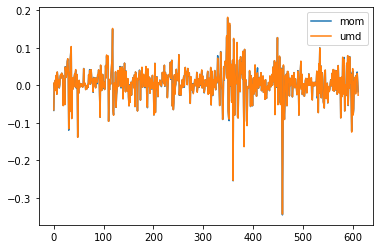

In [92]:
crsp = crsp_checkpoint.copy()

# Assign category through breakpoints

# me or melag??

conditions =[
    (crsp['melag'] < crsp['me_nyse50']),
    (crsp['melag'] >= crsp['me_nyse50']),
]
values = ['Small', 'Big']

crsp['SizeCat'] = np.select(conditions, values)


conditions =[
    (crsp['mom'] < crsp['mom_nyse30']),
    ((crsp['mom'] >= crsp['mom_nyse30']) & (crsp['mom'] < crsp['mom_nyse70'])),
    (crsp['mom'] >= crsp['mom_nyse70'])
]
values = ['Low', 'Medium', 'High']

crsp['MomCat'] = np.select(conditions, values)


# Filter for Momentum Category being 0 (meaning that Momentum is NaN)
crsp = crsp.loc[crsp.MomCat != '0']

# Combine Size and Mom Portfolios
crsp['Port'] = crsp.SizeCat.str.cat(crsp.MomCat, sep='-')



# Calculate total Market equity for value weighting
# Again, me or melag???
total_me = crsp.groupby(['yyyymm', 'Port'])['me'].sum().reset_index(drop=False, name='total_me')
total_melag = crsp.groupby(['yyyymm', 'Port'])['melag'].sum().reset_index(drop=False, name='total_melag')

if 'total_me' in crsp.columns:
    crsp.drop('total_me', axis=1, inplace=True)
if 'total_melag' in crsp.columns:
    crsp.drop('total_melag', axis=1, inplace=True)

    
crsp = crsp.merge(total_me, on=['yyyymm','Port'], how='left')
crsp = crsp.merge(total_melag, on=['yyyymm','Port'], how='left')


# Calculate weights
crsp['pweight'] = crsp['melag']/crsp['total_melag']


# Create portfolio returns
portfolios = (
    crsp
    .groupby(['yyyymm','Port'])
    .apply(lambda x: sum(x['ret'] * x['pweight']))
    .reset_index(name='port_ret', drop=False)
    .drop('level_2',axis=1,errors='ignore')
    .pivot(index='yyyymm', columns='Port', values='port_ret')
    
    )

# Create UMD factor
umd = 0.5*(portfolios['Small-High'] + portfolios['Big-High']) - 0.5 * (portfolios['Small-Low'] + portfolios['Big-Low'])

# Modify famafrench to merge with created mom factor
famafrench['yyyymm'] =  famafrench['date'].apply(lambda x: dt.datetime.strftime(x, '%Y%m')) 
famafrench['yyyymm'] = famafrench.yyyymm.astype(int)
umd = umd.reset_index(name='mom')


# Merge FF Mom with created Mom
momentum_check = pd.merge(umd, famafrench[['yyyymm','umd']], on=['yyyymm'], how='inner')
momentum_check = momentum_check.dropna()
momentum_check = momentum_check.loc[momentum_check.yyyymm >= 197001]

port_corr = stats.pearsonr(momentum_check['mom'], momentum_check['umd'])
print(f'Mom returns correlation: {round(port_corr[0]*100,1)}%')

momentum_check.iloc[:,1:].plot()